<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 5: ASHRAE - Great Energy Predictor III (Part 3a Modeling LGBM)

 - [Modeling](#Modeling)

## Modeling

### Importing Libraries

In [1]:
import pandas as pd
pd.reset_option('^display.', silent=True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import boto3
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor

/home/ubuntu/.local/lib/python3.10/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lofo-importance
# !pip install imblearn
# !pip install smart_open
# !pip install boto3
# !pip install s3fs

In [3]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = '',
    aws_secret_access_key = ''
)

In [4]:
import os
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''

In [5]:
obj = s3.Bucket('jiashengs3').Object('cleaned_train4.csv').get()
obj1 = s3.Bucket('jiashengs3').Object('cleaned_test4.csv').get()

In [6]:
# retriving cleaned train and test datasets from s3 bucket
train_df = pd.read_csv(obj['Body'],index_col=0)
test_df = pd.read_csv(obj1['Body'],index_col=0)

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 4506.58 MB
Memory usage after optimization is: 1239.31 MB
Decreased by 72.5%
Memory usage of dataframe is 9225.70 MB
Memory usage after optimization is: 2465.49 MB
Decreased by 73.3%


#### Ensure consistency between 2 datasets columns 

In [9]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [10]:
train_df.columns.difference(test_df.columns)

Index(['log_meter_reading', 'meter_reading'], dtype='object')

In [11]:
train_df = train_df.drop(columns='meter_reading')

In [12]:
test_df.columns.difference(train_df.columns)

Index(['row_id'], dtype='object')

In [13]:
#Splitting into the 4 different meter types
train_df_0 = train_df[train_df['meter']==0]
train_df_1 = train_df[train_df['meter']==1]
train_df_2 = train_df[train_df['meter']==2]
train_df_3 = train_df[train_df['meter']==3]

In [14]:
#Splitting into the 4 different meter types
test_df_0 = test_df[test_df['meter']==0]
test_df_1 = test_df[test_df['meter']==1]
test_df_2 = test_df[test_df['meter']==2]
test_df_3 = test_df[test_df['meter']==3]

### Feature Selection using Leave One Feature Out (LOFO)

In [15]:
#LOFO on meter 0
cv = KFold(n_splits=2, shuffle=False)
dataset = Dataset(df=train_df_0, target='log_meter_reading', features=[col for col in train_df_0.columns if col != 'log_meter_reading'])

In [16]:
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_squared_log_error")

In [17]:
importance_df = lofo_imp.get_importance()

  0%|          | 0/28 [00:00<?, ?it/s]

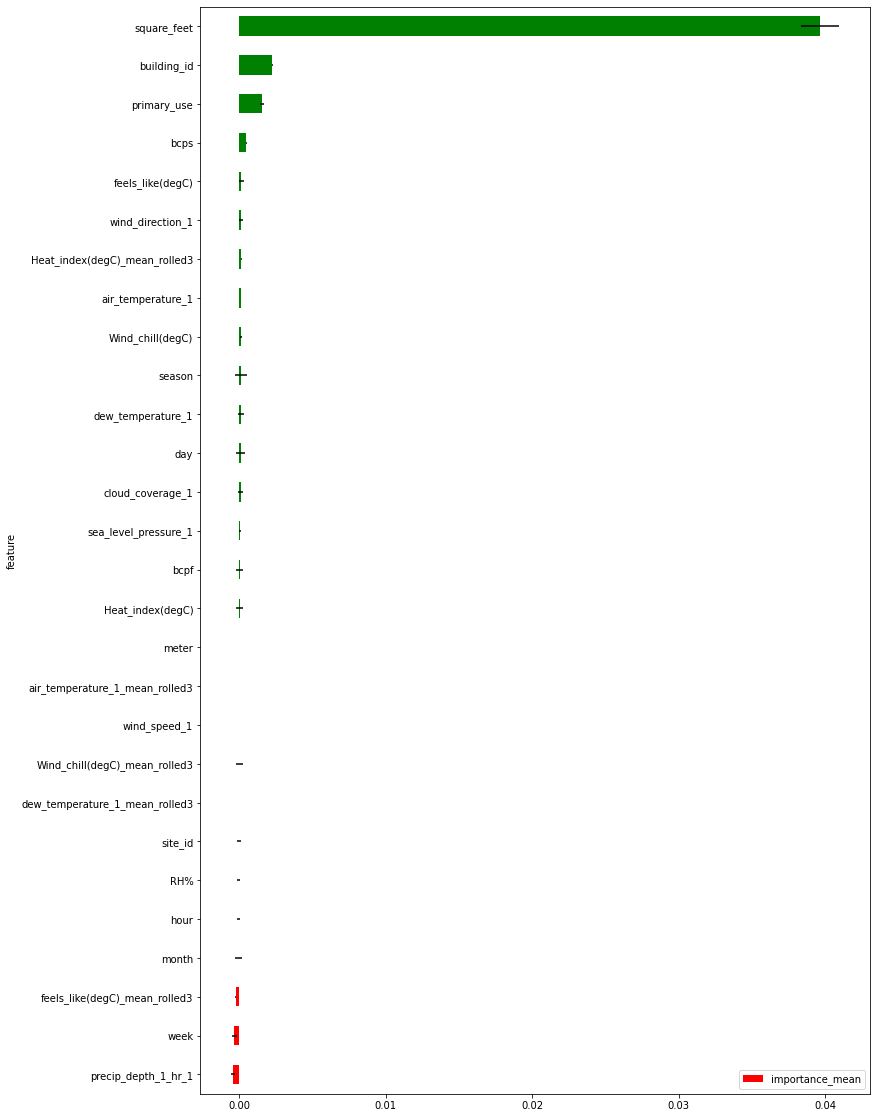

In [18]:
plot_importance(importance_df, figsize=(12, 20))

In [19]:
#identifying good features 
good_features0 = importance_df[~(importance_df['importance_mean'] <0)]

In [20]:
goodfeatures0 = list(good_features0.feature.values)

In [21]:
goodfeatures0

['square_feet',
 'building_id',
 'primary_use',
 'bcps',
 'feels_like(degC)',
 'wind_direction_1',
 'Heat_index(degC)_mean_rolled3',
 'air_temperature_1',
 'Wind_chill(degC)',
 'season',
 'dew_temperature_1',
 'day',
 'cloud_coverage_1',
 'sea_level_pressure_1',
 'bcpf',
 'Heat_index(degC)',
 'meter',
 'air_temperature_1_mean_rolled3',
 'wind_speed_1']

In [22]:
goodfeatures0.remove('meter')

#### Finding the good features for the meters 1, 2 and 3

In [23]:
def findgoodfeatures(df_ls, num_splits):
    
    good_features1 = []
    good_features2 = []
    good_features3 = []
    
    for count, dataframe in enumerate(df_ls):
        
        cv = KFold(n_splits=num_splits, shuffle=False)
        dataset = Dataset(df=dataframe.head(200_000), target='log_meter_reading', features=[col for col in dataframe.columns if col != 'log_meter_reading'])
        lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_squared_log_error")
        importance_df = lofo_imp.get_importance()
        plot_importance(importance_df, figsize=(12, 20))
        
        if count == 0:
            
            good_features1 = importance_df[~(importance_df['importance_mean'] <0)]
            good_features1.append(good_features1)
            
        elif count ==1:
            
            good_features2 = importance_df[~(importance_df['importance_mean'] <0)]
            good_features2.append(good_features2)
        
        else:
            
            good_features3 = importance_df[~(importance_df['importance_mean'] <0)]
            good_features3.append(good_features3)   
        
    return good_features1, good_features2, good_features3


  0%|          | 0/28 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/ubuntu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/tmp/ipykernel_2590/574693191.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  good_features1.append(good_features1)


  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_2590/574693191.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  good_features2.append(good_features2)


  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_2590/574693191.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  good_features3.append(good_features3)


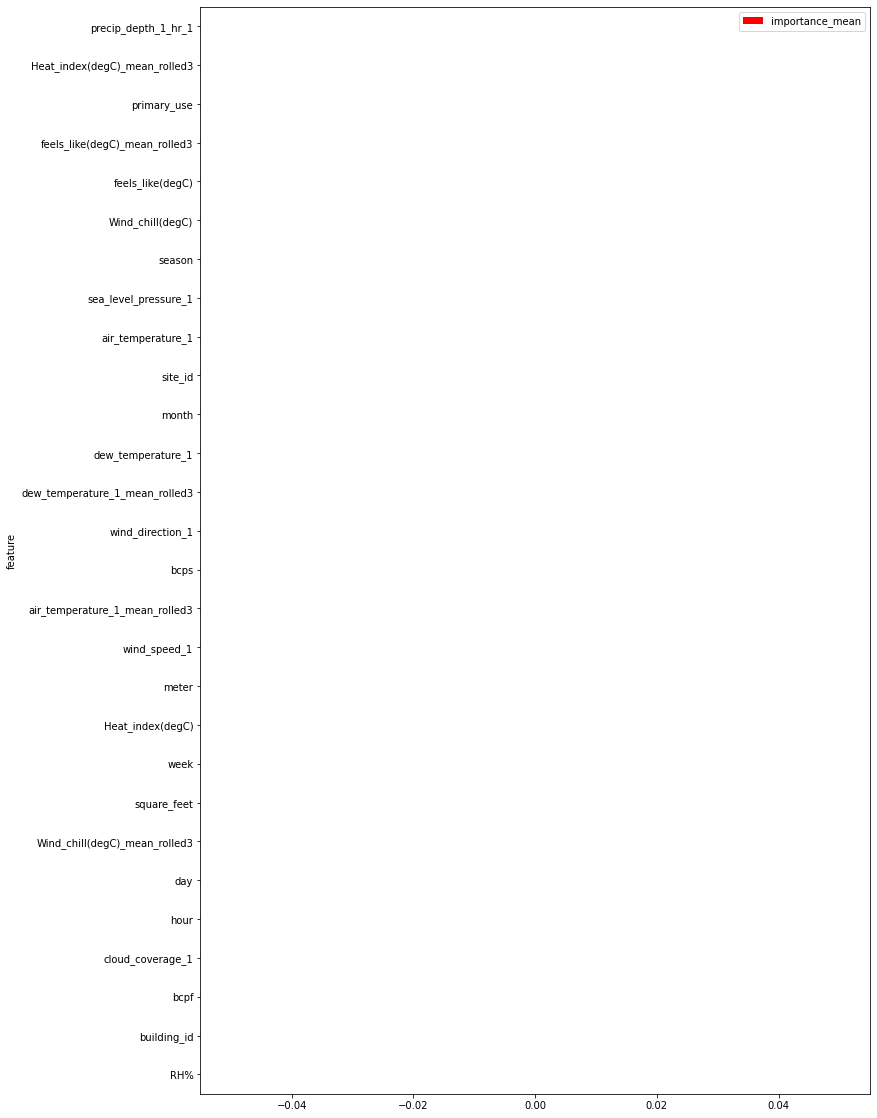

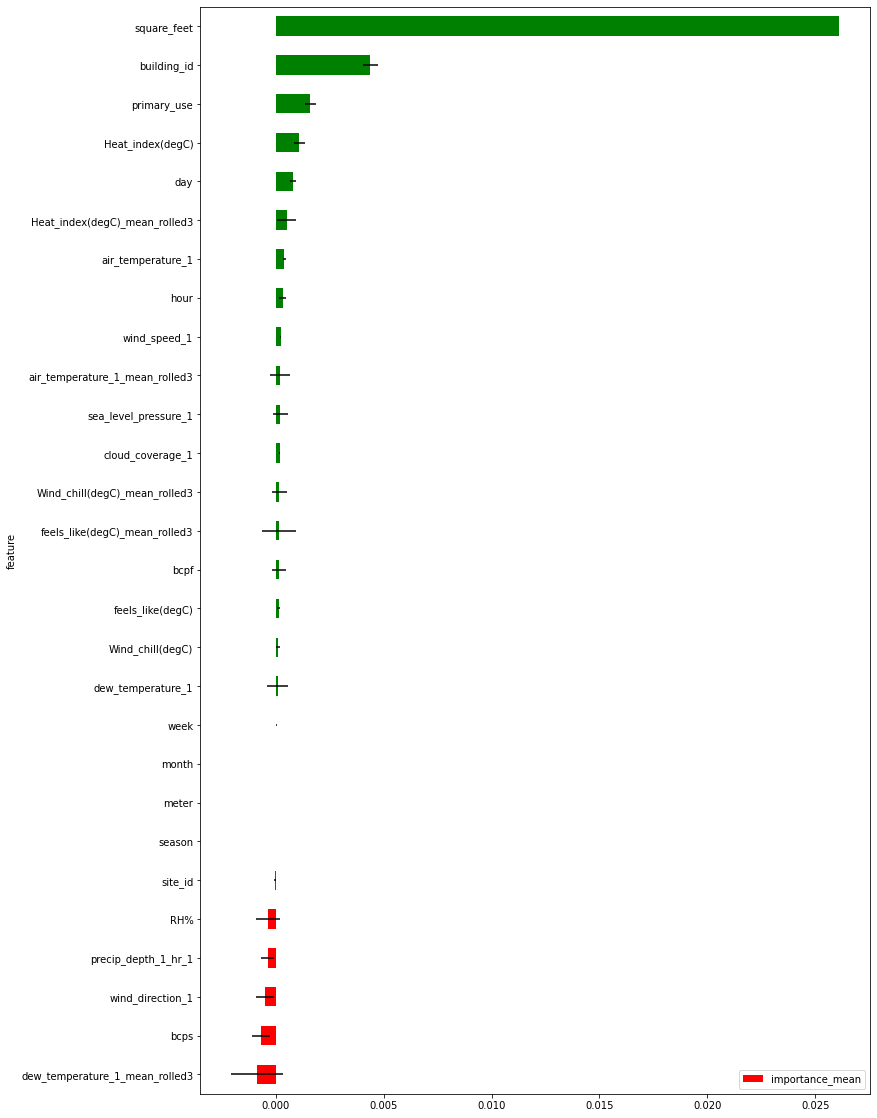

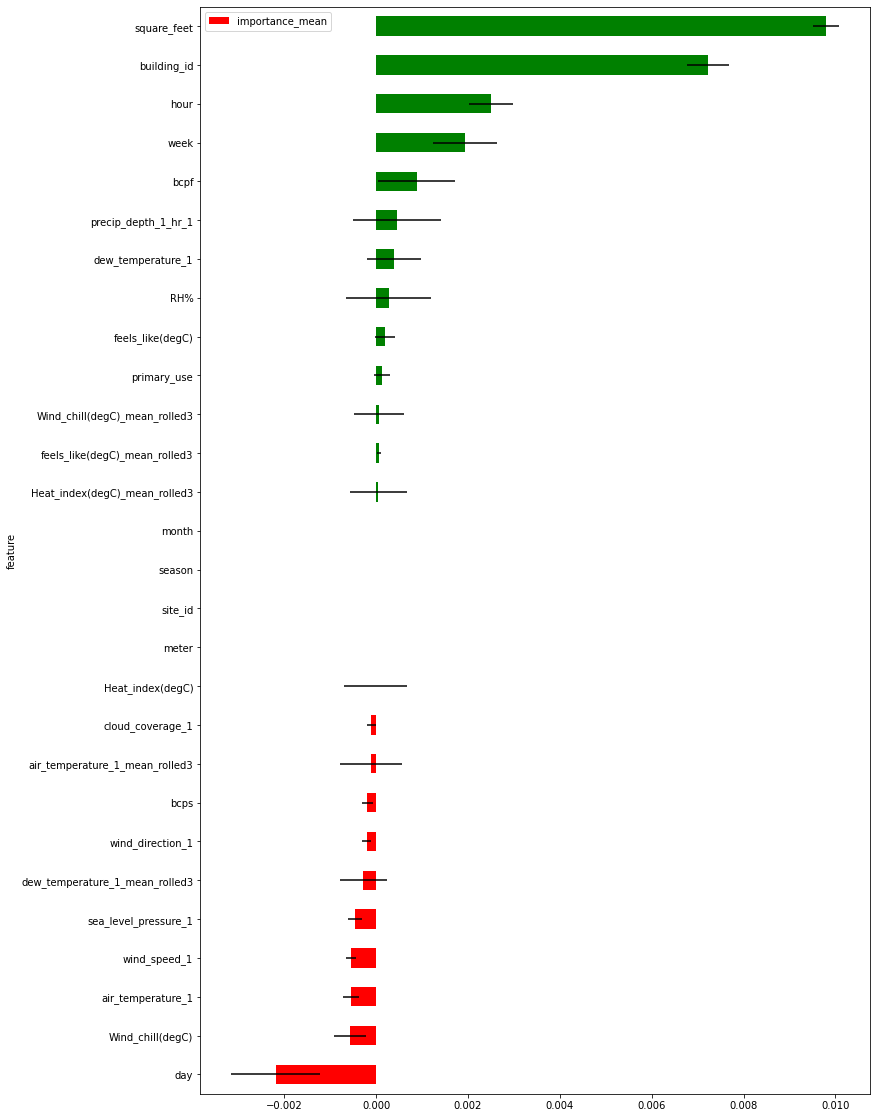

In [24]:
df_ls = [train_df_1, train_df_2, train_df_3] 

good_features1, good_features2, good_features3 = findgoodfeatures(df_ls,2) 

In [25]:
goodfeatures1 = list(train_df.columns)
goodfeatures2 = list(good_features2.feature.values)
goodfeatures3 = list(good_features3.feature.values)

In [28]:
goodfeatures1.remove('meter')

In [33]:
goodfeatures1.remove('log_meter_reading')

In [34]:
goodfeatures2.remove('meter')

In [35]:
goodfeatures2

['square_feet',
 'building_id',
 'primary_use',
 'Heat_index(degC)',
 'day',
 'Heat_index(degC)_mean_rolled3',
 'air_temperature_1',
 'hour',
 'wind_speed_1',
 'air_temperature_1_mean_rolled3',
 'sea_level_pressure_1',
 'cloud_coverage_1',
 'Wind_chill(degC)_mean_rolled3',
 'feels_like(degC)_mean_rolled3',
 'bcpf',
 'feels_like(degC)',
 'Wind_chill(degC)',
 'dew_temperature_1',
 'week',
 'month',
 'season']

In [36]:
goodfeatures3.remove('meter')

In [37]:
goodfeatures3

['square_feet',
 'building_id',
 'hour',
 'week',
 'bcpf',
 'precip_depth_1_hr_1',
 'dew_temperature_1',
 'RH%',
 'feels_like(degC)',
 'primary_use',
 'Wind_chill(degC)_mean_rolled3',
 'feels_like(degC)_mean_rolled3',
 'Heat_index(degC)_mean_rolled3',
 'month',
 'season',
 'site_id']

In [38]:
#number of good features for each meter type
print(f'Number of Good Features for Meter 0 Dataset {len(good_features0)}')
print(f'Number of Good Features for Meter 1 Dataset {len(good_features1)}')
print(f'Number of Good Features for Meter 2 Dataset {len(good_features2)}')
print(f'Number of Good Features for Meter 3 Dataset {len(good_features3)}')

Number of Good Features for Meter 0 Dataset 19
Number of Good Features for Meter 1 Dataset 28
Number of Good Features for Meter 2 Dataset 22
Number of Good Features for Meter 3 Dataset 17


### Hyperparameters Tuning for LightGBM Model (Meter 0)

In [39]:
pd.get_option("display.max_columns")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


def eval_LGBM_model_peformance(X_col,y_col):
    
    # Train Test Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_col,y_col,test_size=0.3,shuffle=False)
    
    # Instantiate model
    lgbm = LGBMRegressor(max_iter=1_000)
    
    #Params Dictionary for Hyperparameters Tuninng
    param_dict = {
                'learning_rate': [0.1],
                'num_leaves': [500,1000,5000],
                'boosting_type':['goss'],
                'reg_alpha': [0.1, 1,10],
                'feature_fraction': [0.85],
                'min_data_in_leaf' : [1000]
    }

    gs = GridSearchCV(lgbm, param_grid=param_dict, cv=2, scoring='r2', verbose=1)
    gs.fit(X_train, y_train)

    #Evaluate
    best_params = gs.best_params_
    best_train_score = gs.best_score_
    test_score = gs.score(X_test, y_test)


    return best_params,best_train_score,test_score

In [40]:
#using subset of training data to find best hyperparameters
train_sample_0 = train_df_0.head(200_000)

In [41]:
X = train_sample_0[goodfeatures0]
y = train_sample_0['log_meter_reading']

In [42]:
best_params,best_train_score,test_score = eval_LGBM_model_peformance(X,y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


In [43]:
print(f'Best Params: {best_params}')
print(f'Best Train Score: {best_train_score}')
print(f'Test Score: {test_score}')

Best Params: {'boosting_type': 'goss', 'feature_fraction': 0.85, 'learning_rate': 0.1, 'min_data_in_leaf': 1000, 'num_leaves': 500, 'reg_alpha': 1}
Best Train Score: 0.8381630754463059
Test Score: 0.9026981874392457


In [44]:
best_params['eval_metric'] = 'rmse'
best_params

{'boosting_type': 'goss',
 'feature_fraction': 0.85,
 'learning_rate': 0.1,
 'min_data_in_leaf': 1000,
 'num_leaves': 500,
 'reg_alpha': 1,
 'eval_metric': 'rmse'}

#### Meter type 0 prediction

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_df_0[goodfeatures0],train_df_0['log_meter_reading'],test_size=0.3,shuffle=False)

lgbm = LGBMRegressor(**best_params)
categorical_features0 = ['building_id','season','day', 'primary_use']

In [46]:
lgbm.fit(X=X_train, y=y_train,categorical_feature=categorical_features0, eval_set = (X_test, y_test), early_stopping_rounds=50)

/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day', 'primary_use', 'season']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 2.05266
[2]	valid_0's l2: 1.73939
[3]	valid_0's l2: 1.47474
[4]	valid_0's l2: 1.28136
[5]	valid_0's l2: 1.10526
[6]	valid_0's l2: 0.963782
[7]	valid_0's l2: 0.862543
[8]	valid_0's l2: 0.767673
[9]	valid_0's l2: 0.691293
[10]	valid_0's l2: 0.62973
[11]	valid_0's l2: 0.578846
[12]	valid_0's l2: 0.545178
[13]	valid_0's l2: 0.509505
[14]	valid_0's l2: 0.480802
[15]	valid_0's l2: 0.459453
[16]	valid_0's l2: 0.438924
[17]	valid_0's l2: 0.426315
[18]	valid_0's l2: 0.412492
[19]	valid_0's l2: 0.401736
[20]	valid_0's l2: 0.393198
[21]	valid_0's l2: 0.388937
[22]	valid_0's l2: 0.391803
[23]	valid_0's l2: 0.386188
[24]	valid_0's l2: 0.382147
[25]	valid_0's l2: 0.38028
[26]	valid_0's l2: 0.376723
[27]	valid_0's l2: 0.374692
[28]	valid_0's l2: 0.372721
[29]	valid_0's l2: 0.371694
[30]	valid_0's l2: 0.371118
[31]	valid_0's l2: 0.369812
[32]	valid_0's l2: 0.36978
[33]	valid_0's l2: 0.370351
[34]	valid_0's l2: 0.369266
[35]	valid_0's l2: 0.369514
[36]	valid_0's l2: 0.368893
[37]	vali

LGBMRegressor(boosting_type='goss', eval_metric='rmse', feature_fraction=0.85,
              min_data_in_leaf=1000, num_leaves=500, reg_alpha=1)

In [47]:
meter0_prediction=lgbm.predict(test_df_0[goodfeatures0])

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

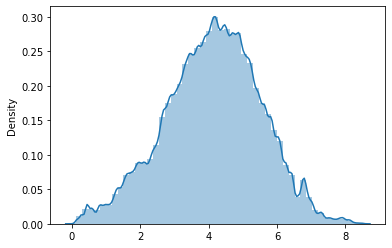

In [48]:
sns.distplot(meter0_prediction)

In [49]:
test_df_0['meter_reading'] = np.expm1(meter0_prediction)

/tmp/ipykernel_2590/1436111146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_0['meter_reading'] = np.expm1(meter0_prediction)


#### Hyperparameters Tuning for Meter 1, 2 and 3

In [51]:
def save_best_params(df_ls):
    
    best_params_meter1 = []
    best_params_meter2 = []
    best_params_meter3 = []
    
    for count, dataframe in enumerate(df_ls):
        
        train_sample = dataframe.head(200_000)
        y = train_sample['log_meter_reading']
        
        if count == 0:
            X = train_sample[goodfeatures1]
            best_params,best_train_score,test_score = eval_LGBM_model_peformance(X,y)   
            best_params_meter1.append(best_params)
            print(f'Dataset with Meter 1 best training score{best_train_score}')
            print(f'Dataset with Meter 1 testing score{test_score}')
        
        elif count ==1:
            X = train_sample[goodfeatures2]
            best_params,best_train_score,test_score = eval_LGBM_model_peformance(X,y)   
            best_params_meter2.append(best_params)
            print(f'Dataset with Meter 2 best training score{best_train_score}')
            print(f'Dataset with Meter 2 testing score{test_score}')
        
        else:
            X = train_sample[goodfeatures3]
            best_params,best_train_score,test_score = eval_LGBM_model_peformance(X,y)   
            best_params_meter3.append(best_params)
            print(f'Dataset with Meter 3 best training score{best_train_score}')
            print(f'Dataset with Meter 3 testing score{test_score}')
        
    return best_params_meter1, best_params_meter2, best_params_meter3
    

In [52]:
best_params_meter1, best_params_meter2, best_params_meter3 = save_best_params([train_df_1,train_df_2,train_df_3])

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Dataset with Meter 1 best training score0.7958877160444893
Dataset with Meter 1 testing score0.8802431726819719
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Dataset with Meter 2 best training score0.7745044652991386
Dataset with Meter 2 testing score0.6920939364288183
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Dataset with Meter 3 best training score0.6993288199572366
Dataset with Meter 3 testing score0.6930297928707875


#### Meter 1 Prediction 

In [53]:
best_params_meter1 = best_params_meter1[0]

In [54]:
goodfeatures1

['building_id',
 'site_id',
 'primary_use',
 'square_feet',
 'month',
 'week',
 'day',
 'hour',
 'air_temperature_1',
 'cloud_coverage_1',
 'dew_temperature_1',
 'precip_depth_1_hr_1',
 'sea_level_pressure_1',
 'wind_direction_1',
 'wind_speed_1',
 'RH%',
 'season',
 'Heat_index(degC)',
 'Wind_chill(degC)',
 'feels_like(degC)',
 'air_temperature_1_mean_rolled3',
 'dew_temperature_1_mean_rolled3',
 'Heat_index(degC)_mean_rolled3',
 'Wind_chill(degC)_mean_rolled3',
 'feels_like(degC)_mean_rolled3',
 'bcps',
 'bcpf']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train_df_1[goodfeatures1],train_df_1['log_meter_reading'],test_size=0.3,shuffle=False)

lgbm = LGBMRegressor(**best_params_meter1)
categorical_features1 = ['building_id', 'site_id', 'month', 'week', 'day', 'hour', 'season', 'primary_use']

In [56]:
lgbm.fit(X=X_train, y=y_train,categorical_feature=categorical_features1, eval_set = (X_test, y_test), early_stopping_rounds=50)

/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day', 'hour', 'month', 'primary_use', 'season', 'site_id', 'week']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 5.84715
[2]	valid_0's l2: 5.33609
[3]	valid_0's l2: 4.85299
[4]	valid_0's l2: 4.48528
[5]	valid_0's l2: 4.14168
[6]	valid_0's l2: 3.81011
[7]	valid_0's l2: 3.61781
[8]	valid_0's l2: 3.40825
[9]	valid_0's l2: 3.20559
[10]	valid_0's l2: 3.08181
[11]	valid_0's l2: 2.95544
[12]	valid_0's l2: 2.84101
[13]	valid_0's l2: 2.77452
[14]	valid_0's l2: 2.69586
[15]	valid_0's l2: 2.62767
[16]	valid_0's l2: 2.58544
[17]	valid_0's l2: 2.55511
[18]	valid_0's l2: 2.52416
[19]	valid_0's l2: 2.49748
[20]	valid_0's l2: 2.4866
[21]	valid_0's l2: 2.46577
[22]	valid_0's l2: 2.4445
[23]	valid_0's l2: 2.43008
[24]	valid_0's l2: 2.42155
[25]	valid_0's l2: 2.41233
[26]	valid_0's l2: 2.40125
[27]	valid_0's l2: 2.396
[28]	valid_0's l2: 2.39097
[29]	valid_0's l2: 2.38583
[30]	valid_0's l2: 2.38017
[31]	valid_0's l2: 2.37529
[32]	valid_0's l2: 2.37231
[33]	valid_0's l2: 2.37297
[34]	valid_0's l2: 2.37167
[35]	valid_0's l2: 2.36883
[36]	valid_0's l2: 2.36945
[37]	valid_0's l2: 2.36643
[38]	valid_0's

LGBMRegressor(boosting_type='goss', feature_fraction=0.85,
              min_data_in_leaf=1000, num_leaves=500, reg_alpha=1)

In [57]:
meter1_prediction=lgbm.predict(test_df_1[goodfeatures1])

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

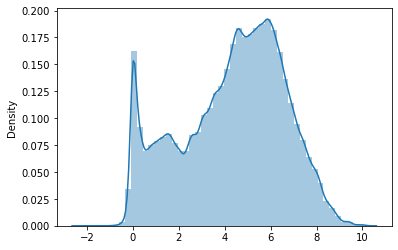

In [58]:
sns.distplot(meter1_prediction)

In [59]:
test_df_1['meter_reading'] = np.expm1(meter1_prediction)

/tmp/ipykernel_2590/1853244971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_1['meter_reading'] = np.expm1(meter1_prediction)


#### Meter 2 Prediction 

In [60]:
best_params_meter2 = best_params_meter2[0]

In [61]:
best_params_meter2

{'boosting_type': 'goss',
 'feature_fraction': 0.85,
 'learning_rate': 0.1,
 'min_data_in_leaf': 1000,
 'num_leaves': 500,
 'reg_alpha': 10}

In [62]:
goodfeatures2

['square_feet',
 'building_id',
 'primary_use',
 'Heat_index(degC)',
 'day',
 'Heat_index(degC)_mean_rolled3',
 'air_temperature_1',
 'hour',
 'wind_speed_1',
 'air_temperature_1_mean_rolled3',
 'sea_level_pressure_1',
 'cloud_coverage_1',
 'Wind_chill(degC)_mean_rolled3',
 'feels_like(degC)_mean_rolled3',
 'bcpf',
 'feels_like(degC)',
 'Wind_chill(degC)',
 'dew_temperature_1',
 'week',
 'month',
 'season']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train_df_2[goodfeatures2],train_df_2['log_meter_reading'],test_size=0.3,shuffle=False)

lgbm = LGBMRegressor(**best_params_meter2)
categorical_features2 = ['building_id', 'day', 'week', 'hour', 'season', 'month', 'primary_use']

In [64]:
lgbm.fit(X=X_train, y=y_train,categorical_feature=categorical_features2, eval_set = (X_test, y_test), early_stopping_rounds=50)

/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day', 'hour', 'month', 'primary_use', 'season', 'week']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 5.64577
[2]	valid_0's l2: 4.99196
[3]	valid_0's l2: 4.41804
[4]	valid_0's l2: 4.00551
[5]	valid_0's l2: 3.68967
[6]	valid_0's l2: 3.48649
[7]	valid_0's l2: 3.27159
[8]	valid_0's l2: 3.07229
[9]	valid_0's l2: 2.8977
[10]	valid_0's l2: 2.79009
[11]	valid_0's l2: 2.70565
[12]	valid_0's l2: 2.62722
[13]	valid_0's l2: 2.57353
[14]	valid_0's l2: 2.52901
[15]	valid_0's l2: 2.4959
[16]	valid_0's l2: 2.46672
[17]	valid_0's l2: 2.44573
[18]	valid_0's l2: 2.42669
[19]	valid_0's l2: 2.4175
[20]	valid_0's l2: 2.40385
[21]	valid_0's l2: 2.39999
[22]	valid_0's l2: 2.38558
[23]	valid_0's l2: 2.37763
[24]	valid_0's l2: 2.37356
[25]	valid_0's l2: 2.37433
[26]	valid_0's l2: 2.37481
[27]	valid_0's l2: 2.37966
[28]	valid_0's l2: 2.37637
[29]	valid_0's l2: 2.37566
[30]	valid_0's l2: 2.37298
[31]	valid_0's l2: 2.37073
[32]	valid_0's l2: 2.36257
[33]	valid_0's l2: 2.36243
[34]	valid_0's l2: 2.35485
[35]	valid_0's l2: 2.3477
[36]	valid_0's l2: 2.34994
[37]	valid_0's l2: 2.34897
[38]	valid_0's

LGBMRegressor(boosting_type='goss', feature_fraction=0.85,
              min_data_in_leaf=1000, num_leaves=500, reg_alpha=10)

In [65]:
meter2_prediction=lgbm.predict(test_df_2[goodfeatures2])

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

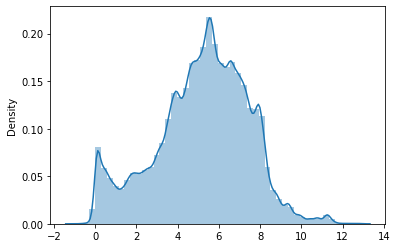

In [66]:
sns.distplot(meter2_prediction)

In [67]:
test_df_2['meter_reading'] = np.expm1(meter2_prediction)

/tmp/ipykernel_2590/23908708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_2['meter_reading'] = np.expm1(meter2_prediction)


#### Meter 3 Prediction 

In [68]:
best_params_meter3 = best_params_meter3[0]
best_params_meter3

{'boosting_type': 'goss',
 'feature_fraction': 0.85,
 'learning_rate': 0.1,
 'min_data_in_leaf': 1000,
 'num_leaves': 500,
 'reg_alpha': 1}

In [69]:
goodfeatures3

['square_feet',
 'building_id',
 'hour',
 'week',
 'bcpf',
 'precip_depth_1_hr_1',
 'dew_temperature_1',
 'RH%',
 'feels_like(degC)',
 'primary_use',
 'Wind_chill(degC)_mean_rolled3',
 'feels_like(degC)_mean_rolled3',
 'Heat_index(degC)_mean_rolled3',
 'month',
 'season',
 'site_id']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(train_df_3[goodfeatures3],train_df_3['log_meter_reading'],test_size=0.3,shuffle=False)

lgbm = LGBMRegressor(**best_params_meter3)
categorical_features3 = ['building_id', 'week', 'hour', 'season', 'site_id', 'month', 'primary_use']

In [71]:
lgbm.fit(X=X_train, y=y_train,categorical_feature=categorical_features3, eval_set = (X_test, y_test), early_stopping_rounds=50)

/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'hour', 'month', 'primary_use', 'season', 'site_id', 'week']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/ubuntu/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 6.03519
[2]	valid_0's l2: 5.37165
[3]	valid_0's l2: 4.87778
[4]	valid_0's l2: 4.4398
[5]	valid_0's l2: 4.08354
[6]	valid_0's l2: 3.84599
[7]	valid_0's l2: 3.62345
[8]	valid_0's l2: 3.47611
[9]	valid_0's l2: 3.35305
[10]	valid_0's l2: 3.25718
[11]	valid_0's l2: 3.16595
[12]	valid_0's l2: 3.09848
[13]	valid_0's l2: 3.053
[14]	valid_0's l2: 3.02659
[15]	valid_0's l2: 3.00994
[16]	valid_0's l2: 2.99205
[17]	valid_0's l2: 2.98479
[18]	valid_0's l2: 2.97239
[19]	valid_0's l2: 2.96714
[20]	valid_0's l2: 2.96215
[21]	valid_0's l2: 2.95985
[22]	valid_0's l2: 2.96522
[23]	valid_0's l2: 2.96868
[24]	valid_0's l2: 2.96994
[25]	valid_0's l2: 2.97246
[26]	valid_0's l2: 2.97644
[27]	valid_0's l2: 2.97559
[28]	valid_0's l2: 2.97533
[29]	valid_0's l2: 2.97603
[30]	valid_0's l2: 2.97403
[31]	valid_0's l2: 2.98172
[32]	valid_0's l2: 2.98097
[33]	valid_0's l2: 2.98238
[34]	valid_0's l2: 2.98305
[35]	valid_0's l2: 2.9845
[36]	valid_0's l2: 2.98804
[37]	valid_0's l2: 2.98689
[38]	valid_0's

LGBMRegressor(boosting_type='goss', feature_fraction=0.85,
              min_data_in_leaf=1000, num_leaves=500, reg_alpha=1)

In [72]:
meter3_prediction=lgbm.predict(test_df_3[goodfeatures3])

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

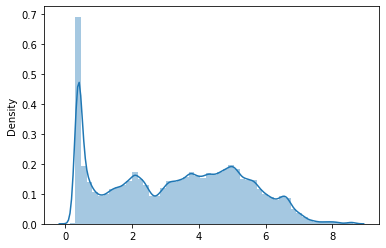

In [73]:
sns.distplot(meter3_prediction)

In [74]:
test_df_3['meter_reading'] = np.expm1(meter3_prediction)

/tmp/ipykernel_2590/3586089744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_3['meter_reading'] = np.expm1(meter3_prediction)


#### Concatenate all predicted datasets

In [75]:
concat_df = [test_df_0, test_df_1, test_df_2, test_df_3]

kaggle_test_df = pd.concat(concat_df, axis=0)

In [76]:
test_df.shape

(41697600, 29)

In [77]:
kaggle_submission = kaggle_test_df[['row_id','meter_reading']]

In [78]:
kaggle_submission = kaggle_submission.sort_values(by='row_id')

In [79]:
kaggle_submission.to_csv('s3://jiashengs3/kaggle_submission(LGBM).csv', index=False)